# Phase II: Deterministic Loss Reserving via the Chain-Ladder Method

## 1. Overview and Objectives

This notebook represents the second phase of the "Actuarial Loss Triangle Analysis Using Chain-Ladder and Machine Learning" project. Building upon the exploratory phase (`data_exploration.ipynb`), the **Personal Auto (ppauto)** line of business was selected for its data completeness, credibility, and the feasibility of constructing a full $10 \times 10$ development triangle.

### Purpose

The primary objective is to establish a deterministic benchmark for estimating **ultimate losses** and **Incurred But Not Reported (IBNR)** reserves using the classical **Chain-Ladder (CL)** method. The outputs from this phase will serve as a reference for evaluating the performance of stochastic and machine learning reserving techniques in future modules.

## 2. Data Loading and Preparation

In [30]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to the raw data directory
RAW_DATA_PATH = "../data/raw/"

# List and load all CSV files into a dictionary of DataFrames
csv_files = [f for f in os.listdir(RAW_DATA_PATH) if f.endswith('.csv')]
datasets = {}
for file in csv_files:
    name = file.split('.')[0].replace('_pos', '')
    datasets[name] = pd.read_csv(os.path.join(RAW_DATA_PATH, file))

print(f"Data ingestion complete. Available datasets: {list(datasets.keys())}")

# Configure plot style for consistency
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

def print_lob_summary(df, lob_name):
    """Prints a concise summary of a Line of Business DataFrame."""
    loss_col = [col for col in df.columns if 'CumPaidLoss' in col][0]
    print(f"--- Summary for: {lob_name} ---")
    print(f"Shape: {df.shape}")
    print(f"Accident Years: {df['AccidentYear'].min()}-{df['AccidentYear'].max()}")
    print("\nStatistics for Cumulative Paid Loss:")
    stats = df[loss_col].describe()
    summary_view = stats[['mean', 'std', 'min', '50%', 'max']]
    summary_view.index = ['Mean', 'Std Dev', 'Min', 'Median', 'Max']
    print(summary_view.to_string(float_format=lambda x: f'{x:,.2f}'))
    print("-"*40)

# Select ppauto dataset and process it
df = datasets.get('ppauto')
if df is None:
    raise ValueError("ppauto dataset not found in loaded datasets")

# Filter for single carriers and select the largest GRCODE
df_single = df[df['Single'] == 1].copy()
largest_group_code = df_single.groupby('GRCODE')['CumPaidLoss_B'].sum().idxmax()
df_selected = df_single[df_single['GRCODE'] == largest_group_code].copy()
df_selected['CumPaidLoss_B'] = df_selected['CumPaidLoss_B'].clip(lower=0)

# Print summary for the selected ppauto data
print_lob_summary(df_selected, f"ppauto (GRCODE: {largest_group_code})")

# Create loss triangle
loss_triangle = df_selected.pivot_table(
    index='AccidentYear',
    columns='DevelopmentLag',
    values='CumPaidLoss_B'
)

# Display loss triangle with corrected formatting
display(loss_triangle.style.format('{:.0f}'))

Data ingestion complete. Available datasets: ['comauto', 'medmal', 'othliab', 'ppauto', 'prodliab', 'wkcomp']
--- Summary for: ppauto (GRCODE: 14176) ---
Shape: (100, 13)
Accident Years: 1988-1997

Statistics for Cumulative Paid Loss:
Mean      12,119.51
Std Dev    5,165.48
Min        1,882.00
Median    11,678.50
Max       21,440.00
----------------------------------------


DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,1882,3873,5417,5907,6487,6519,6563,6665,6667,6674
1989,2708,5316,7056,7698,7971,8231,8329,8335,8334,8408
1990,3547,7611,9649,10451,10889,11000,11070,11097,11171,11210
1991,3882,7599,10443,11458,11899,11963,11989,12027,12082,12058
1992,3628,7103,8772,9969,10225,10340,10375,10418,10456,10492
1993,3918,8903,12157,13212,13440,13614,13679,13699,13704,13715
1994,5329,11996,15074,16397,16872,17075,17229,17258,17273,17320
1995,5904,12832,15348,16329,16804,16964,17219,17432,17450,17511
1996,7557,14881,18520,20281,20875,21190,21400,21381,21408,21440


> **Actuarial Note:** Filtering to a homogeneous group with stable development behavior is essential to meet the Chain-Ladder method’s stationarity assumption.

## 3. Chain-Ladder Framework and Execution

<details>
<summary><strong>Mathematical Derivation and Methodology</strong></summary>

Given a cumulative paid loss matrix $C = \{ C_{i,j} \}$, where $i$ indexes accident year and $j$ development lag:

1. **Age-to-Age Factors** ($\hat{f}_j$):

$$
\hat{f}_j = \frac{\sum_{i=1}^{N-j} C_{i, j+1}}{\sum_{i=1}^{N-j} C_{i, j}}
$$

2. **Cumulative Development Factors** ($\hat{F}_j$):

$$
\hat{F}_j = \prod_{k=j}^{N-1} \hat{f}_k \quad \text{(assuming } f_{\text{tail}} = 1.0 \text{)}
$$

3. **Ultimate Loss Projections**:

$$
\hat{U}_i = C_{i, N-i+1} \cdot \hat{F}_{N-i+1}
$$

4. **IBNR Reserve**:

$$
\text{IBNR}_i = \hat{U}_i - C_{i, N-i+1}, \quad \text{Total IBNR} = \sum_{i=1}^{N} \text{IBNR}_i
$$

</details>

In [31]:
N = loss_triangle.shape[1]
ata_factors = [
    loss_triangle.iloc[:N-j-1, j+1].sum() / loss_triangle.iloc[:N-j-1, j].sum()
    if loss_triangle.iloc[:N-j-1, j].sum() != 0 else 1.0
    for j in range(N - 1)
]
ata_factors = pd.Series(ata_factors, index=[f'{j+1}-{j+2}' for j in range(len(ata_factors))])
cdfs = ata_factors[::-1].cumprod()[::-1]

latest_diagonal = np.diag(loss_triangle.values)
latest_losses = pd.Series(latest_diagonal, index=loss_triangle.index, name='Latest_Observed_Loss')
cdf_for_projection = pd.Series([1.0] * N, index=loss_triangle.index)
cdf_for_projection.iloc[:-1] = cdfs.values
ultimate_losses = latest_losses * cdf_for_projection
ibnr_reserve = ultimate_losses - latest_losses

results_summary = pd.DataFrame({
    'Latest_Observed_Loss': latest_losses,
    'Ultimate_Loss': ultimate_losses,
    'IBNR_Reserve': ibnr_reserve
})

display(results_summary.style.format('{:.0f}'))
print(f"\nTotal Estimated IBNR Reserve: {results_summary['IBNR_Reserve'].sum():.0f}")

,Latest_Observed_Loss,Ultimate_Loss,IBNR_Reserve
AccidentYear,,,
1988,1882,5891,4009
1989,5316,7967,2651
1990,9649,11241,1592
1991,11458,12189,731
1992,10225,10482,257
1993,13614,13787,173
1994,17229,17338,109
1995,17432,17451,19
1996,21408,21430,22



Total Estimated IBNR Reserve: 9563


## 4. Diagnostic Evaluation

### 4.1 Visual Diagnostics

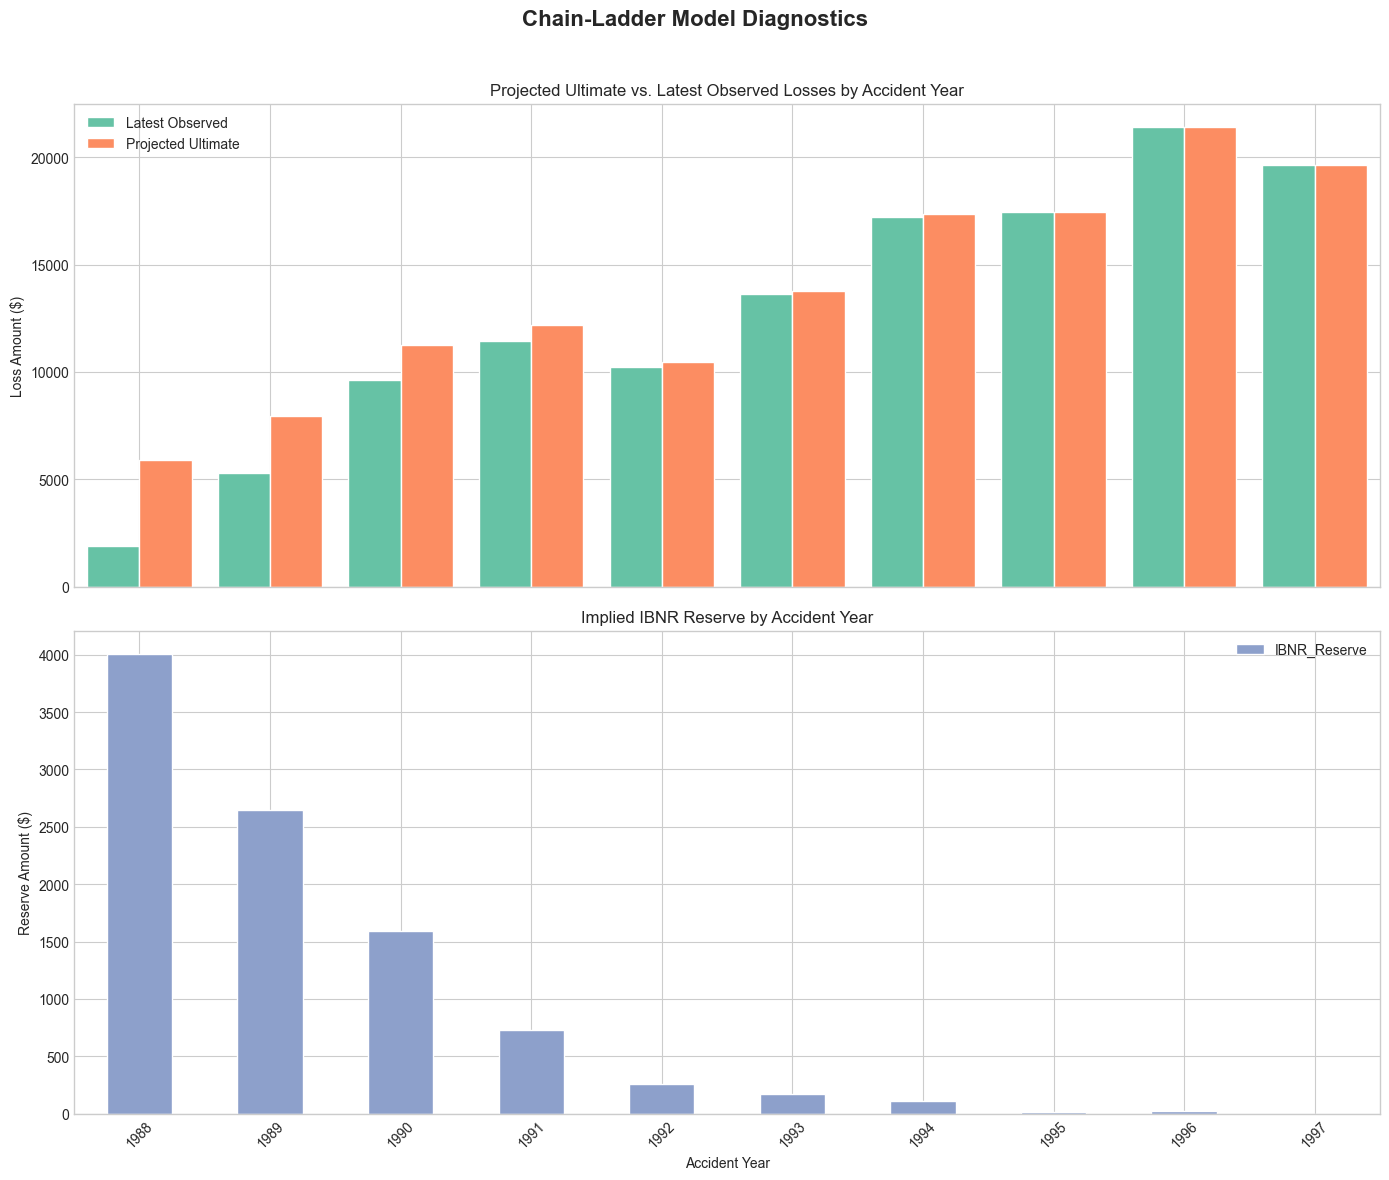

In [32]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
fig.suptitle('Chain-Ladder Model Diagnostics', fontsize=16, fontweight='bold')

results_summary.plot(kind='bar', y=['Latest_Observed_Loss', 'Ultimate_Loss'], ax=ax1,
                     color=['#66c2a5', '#fc8d62'], width=0.8)
ax1.set_title('Projected Ultimate vs. Latest Observed Losses by Accident Year', fontsize=12)
ax1.set_ylabel('Loss Amount ($)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['Latest Observed', 'Projected Ultimate'])

results_summary.plot(kind='bar', y='IBNR_Reserve', ax=ax2, color='#8da0cb')
ax2.set_title('Implied IBNR Reserve by Accident Year', fontsize=12)
ax2.set_xlabel('Accident Year')
ax2.set_ylabel('Reserve Amount ($)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 4.2 Residual Heatmap Analysis

C:\Users\furkz\AppData\Local\Temp\ipykernel_8476\123166230.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  residuals = residuals.fillna(0)


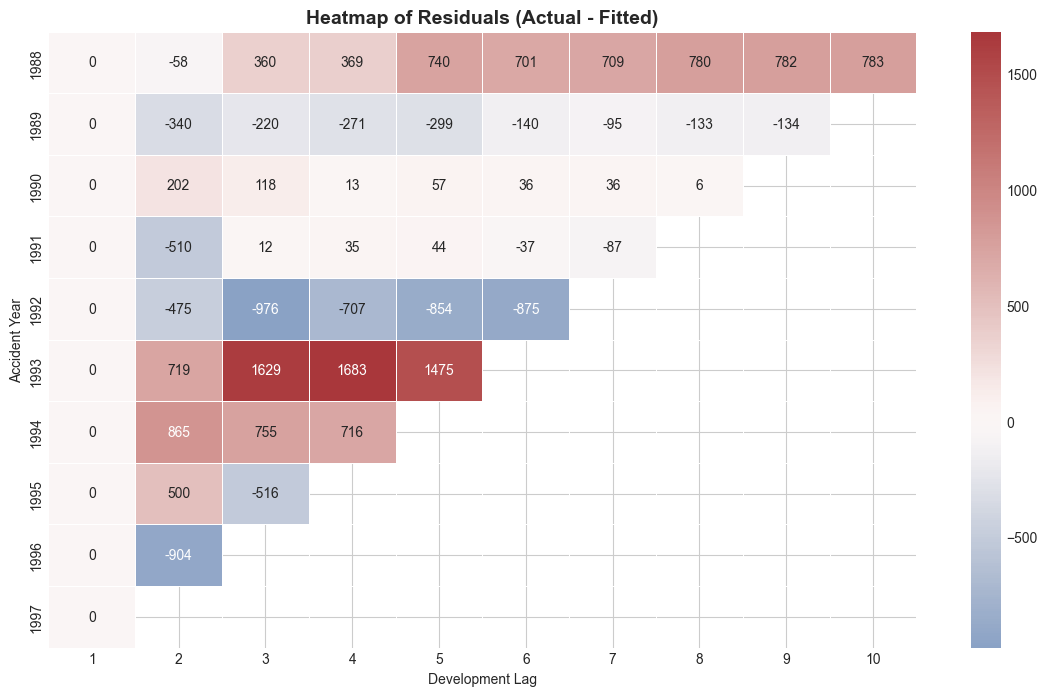

In [33]:
fitted_triangle = pd.DataFrame(index=loss_triangle.index, columns=loss_triangle.columns)
fitted_triangle.iloc[:, 0] = loss_triangle.iloc[:, 0]

for j in range(N - 1):
    fitted_triangle.iloc[:, j+1] = fitted_triangle.iloc[:, j] * ata_factors.iloc[j]

residuals = loss_triangle - fitted_triangle
residuals = residuals.fillna(0) 
mask = np.fromfunction(lambda i, j: i + j >= N, residuals.shape, dtype=int)

plt.figure(figsize=(14, 8))
sns.heatmap(residuals, mask=mask, annot=True, fmt=".0f", cmap='vlag', center=0, linewidths=.5)
plt.title('Heatmap of Residuals (Actual - Fitted)', fontsize=14, fontweight='bold')
plt.xlabel('Development Lag')
plt.ylabel('Accident Year')
plt.show()

> **Interpretation:** Systematic deviations in residuals across development years may signal violations of stationarity, motivating more robust stochastic or machine learning methods in future phases.

## 5. Conclusion and Roadmap

### Summary

* Implemented the deterministic Chain-Ladder model using cumulative paid losses.
* Derived ultimate losses and IBNR estimates based on volume-weighted development patterns.
* Performed residual diagnostics to assess the validity of assumptions.

### Recommendations for Future Phases

1. **Bootstrap Chain-Ladder**: Quantify process and parameter risk.
2. **Machine Learning Models**: Train models on granular claim-level data for complex pattern recognition.
3. **Model Comparison**: Benchmark ML and stochastic methods against deterministic outcomes using metrics like prediction accuracy, bias, and reserve distributional characteristics.
4. **Final Reporting**: Synthesize all insights into a consolidated actuarial recommendation.